Project focused on using various ML models to attempt to predict whether customers of a bank would purchase a hypothetical Variable Rate Annuity (VRA) product. The goal of the project was determine which of these machine learning models performed the best using this dataset

Models assessed:
- Random Forest
- XGBoost
- Neural Network
- Naive Bayes

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    RocCurveDisplay,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [2]:
# load common datasets
training = pd.read_csv("training.csv")
validation = pd.read_csv("validation.csv")

training.isna().sum()
# Large number of missing values, the "bank" in the project specifies we should use median and mode imputation for continuous and categorical variables respectively
# Several of the values, PHONE, POS, POSAMT, INV, INVBAL, CC, CCBAL, CCPURC all have the same number of missing values at 1075. Income LORES, HMVAL as well at 1537
# Logically, it seems that because these variables have similar values of missing they could incidate some account type, i.e. savings account with no investments or credit card
# Therefore these columns will be imputed with 0 and a new column will be created indicating that they were imputed. ACCTAGE and CRSCORE will be imputed with median.

ACCTAGE     546
DDA           0
DDABAL        0
DEP           0
DEPAMT        0
CHECKS        0
DIRDEP        0
NSF           0
NSFAMT        0
PHONE      1075
TELLER        0
SAV           0
SAVBAL        0
ATM           0
ATMAMT        0
POS        1075
POSAMT     1075
CD            0
CDBAL         0
IRA           0
IRABAL        0
INV        1075
INVBAL     1075
MM            0
MMBAL         0
MMCRED        0
CC         1075
CCBAL      1075
CCPURC     1075
SDB           0
INCOME     1537
LORES      1537
HMVAL      1537
AGE        1702
CRSCORE     195
INAREA        0
INS           0
BRANCH        0
dtype: int64

In [ ]:
constant_missing = [
    "PHONE",
    "POS",
    "POSAMT",
    "INV",
    "INVBAL",
    "CC",
    "CCBAL",
    "CCPURC",
    "INCOME",
    "LORES",
    "HMVAL",
]
median_missing = ["AGE", "ACCTAGE", "CRSCORE"]

special_imputer = SimpleImputer(
    strategy="constant", fill_value=0, add_indicator=True
).set_output(transform="pandas")
special_imputed = special_imputer.fit_transform(training[constant_missing])
val_s_imputed = special_imputer.fit_transform(validation[constant_missing])

median_imputer = SimpleImputer(strategy="median", add_indicator=True).set_output(
    transform="pandas"
)
median_imputed = median_imputer.fit_transform(training[median_missing])
val_m_imputed = median_imputer.fit_transform(validation[median_missing])

imputed_training = pd.concat(
    [
        training.drop(constant_missing + median_missing, axis=1),
        special_imputed,
        median_imputed,
    ],
    axis=1,
)
imputed_validation = pd.concat(
    [
        validation.drop(constant_missing + median_missing, axis=1),
        val_s_imputed,
        val_m_imputed,
    ],
    axis=1,
)
# Additionally, sklearn requires that all values for RF to be in integer form, so we will need to encode them
le = LabelEncoder()
imputed_training["BRANCH"] = le.fit_transform(imputed_training["BRANCH"])
imputed_validation["BRANCH"] = le.fit_transform(imputed_validation["BRANCH"])

### Random Forest
1. Tune Random Forest
2. Assess Random Forest against hold-out validation set
3. Perform variable selection
4. Reasses model

In [ ]:
# Grid search RF params (this takes forever and is probably a bit too liberal with the combinations of parameters)
# Best params: Yes bootstrap, 9 features, 800 estimators
rf_param_grid = {
    "bootstrap": [True, False],
    "n_estimators": [x for x in range(100, 900, 100)],
    "max_features": [x for x in range(3, 16, 2)],
}

rf = RandomForestRegressor(random_state=123456)

grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=10, n_jobs=-1)

grid_search.fit(imputed_training.drop("INS", axis=1), imputed_training["INS"])

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=123456),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_features': [3, 5, 7, 9, 11, 13, 15],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 700,
                                          800]})

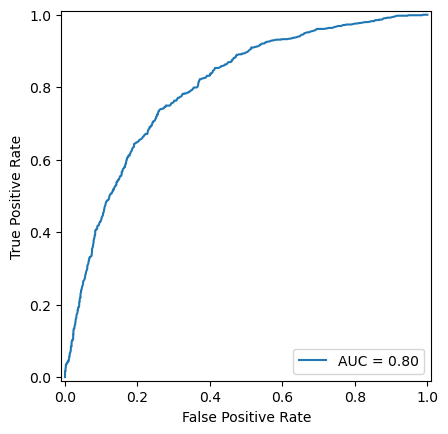

In [ ]:
real_y = imputed_validation["INS"]
pred_y = grid_search.predict(imputed_validation.drop("INS", axis=1))

fpr, tpr, thresholds = roc_curve(real_y, pred_y)
roc_auc = roc_auc_score(real_y, pred_y)

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

# AUC maximized at threshold of ~0.401

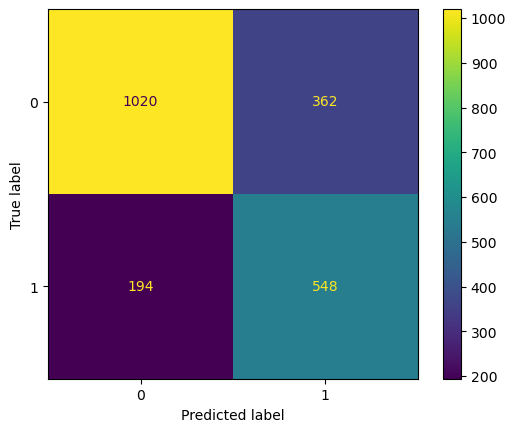

In [ ]:
pred_y = [1 if x >= thresholds[np.argmax(tpr - fpr)] else 0 for x in pred_y]
ConfusionMatrixDisplay.from_predictions(real_y, pred_y)

#### Variable Selection Using Random Variable

In [ ]:
rf2 = RandomForestRegressor(
    bootstrap=True, max_features=9, n_estimators=800, random_state=123456
)
imputed_training_rand = imputed_training
imputed_training_rand["rand"] = np.random.rand(imputed_training.shape[0])
rf2.fit(imputed_training_rand.drop("INS", axis=1), imputed_training_rand["INS"])

RandomForestRegressor(max_features=9, n_estimators=800, random_state=123456)

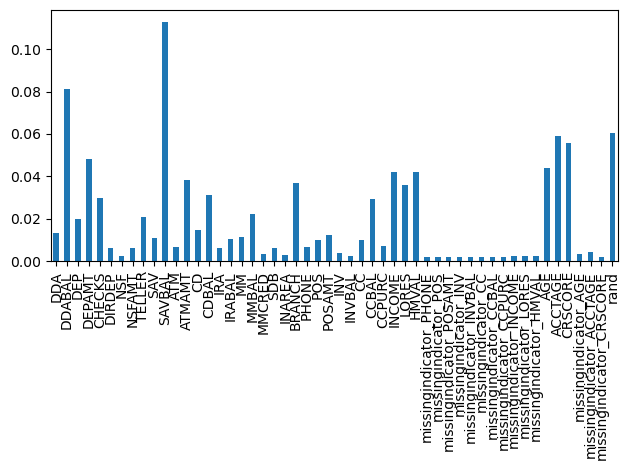

In [ ]:
fig, ax = plt.subplots()
pd.Series(rf2.feature_importances_, rf2.feature_names_in_).plot.bar()
fig.tight_layout()

It appears that only two variables have more of an effect on decrease in purity than a purely random variable. Based on this let us assess the performance of the model containing just these two variables against the full model.

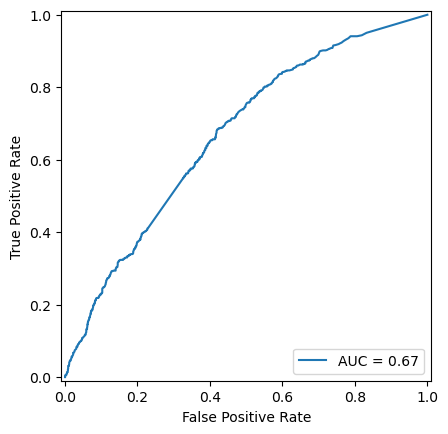

In [ ]:
imputed_training_small = imputed_training[["DDABAL", "SAVBAL", "INS"]]

imputed_validation_small = imputed_validation[["DDABAL", "SAVBAL", "INS"]]
rf2.fit(imputed_training_small.drop("INS", axis=1), imputed_training_small["INS"])

pred_y = rf2.predict(imputed_validation_small.drop("INS", axis=1))
real_y = imputed_validation_small["INS"]

fpr, tpr, thresholds = roc_curve(real_y, pred_y)
roc_auc = roc_auc_score(real_y, pred_y)

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

# AUC decreases pretty substantially to 0.67